In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,25,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,10)]).dropna()
Data = data.values

X = Data[:,:5]

X_norm = x_normalizer(X)

a = np.linspace(0,7,8,dtype=int)
#ind = np.array(random.sample(a.tolist(),6),int)
test_index = [0,1,2] #ind#[0,1,2,3,4,5,6,7]    best  [23  6 20  4  1 19 17 22]
train_index = np.delete(a,test_index)#

index=6
Train_X = X_norm[train_index,:]
Test_X = X_norm[test_index,:]
# Train_y = Data[train_index,index]
# Test_y = Data[test_index,index]
# ss_y = StandardScaler()

ss_y = 0.3
Train_y = Data[train_index,index]/ss_y
Test_y = Data[test_index,index]/ss_y


In [5]:
data

,Tip Height \n(mm) 0.5-50,Dispense Speed \n(ul/s) 20-500,AS Spin Speed \n(rpm) 500-7000,AS Volume \n(ul) 50-300,Timing AS\n (s) 2-25,PL Intensity ave,PL Intensity CV,Peak CV,PLQY
0,1.5,90.0,5600.0,50.0,12.0,175357.061097,0.173763,0.001152,0.337201
1,20.0,460.0,2300.0,220.0,25.0,178837.692437,0.309365,0.001924,0.333660
2,4.0,250.0,7000.0,300.0,22.0,324724.062188,0.119376,0.000455,0.325180
3,8.0,260.0,4900.0,100.0,5.0,251923.044783,0.227518,0.000707,0.321183
4,15.5,170.0,5100.0,70.0,7.0,228986.076923,0.144984,0.000439,0.335772
5,29.5,380.0,5800.0,100.0,13.0,241866.564743,0.123097,0.001060,0.310272
6,32.0,450.0,800.0,140.0,15.0,188744.000000,0.099226,0.000456,0.393455
7,50.0,200.0,1700.0,110.0,6.0,245398.692308,0.099245,0.000540,0.444454


In [6]:
Train_y

array([0.75839459, 0.48327929, 0.41032203, 0.33075321, 0.33081659])

In [7]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.sde_Matern52(input_dim=5,ARD =True)
#poly = GPy.kern.Poly(input_dim=5)
kernel = rbf
model = GPy.models.GPRegression(Train_X,Train_y.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

y_pred_train = model.predict(Train_X)[0].ravel()
y_pred_test = model.predict(Test_X)[0].ravel()
var_train = np.sqrt(model.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model.predict(Test_X)[1]).ravel()

Optimization restart 1/50, f = -0.6563991048996516
Optimization restart 2/50, f = -0.6563990725996169
Optimization restart 3/50, f = -0.65639909086156
Optimization restart 4/50, f = -0.6563990601484448
Optimization restart 5/50, f = -0.6563991011276271
Optimization restart 6/50, f = -0.6563990973678862
Optimization restart 7/50, f = -0.6563990959141366
Optimization restart 8/50, f = -0.6563991011583004
Optimization restart 9/50, f = -0.6563991047924791
Optimization restart 10/50, f = -0.3729224926032697
Optimization restart 11/50, f = -0.6563990868079772
Optimization restart 12/50, f = -0.3729225136250536
Optimization restart 13/50, f = -0.6563990954001002
Optimization restart 14/50, f = -0.6563991041216748
Optimization restart 15/50, f = -0.6563990431761133
Optimization restart 16/50, f = -0.6563987790341246
Optimization restart 17/50, f = -0.6563990956236396
Optimization restart 18/50, f = -0.6563989918039637
Optimization restart 19/50, f = -0.6563990949512588
Optimization restart 20

 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


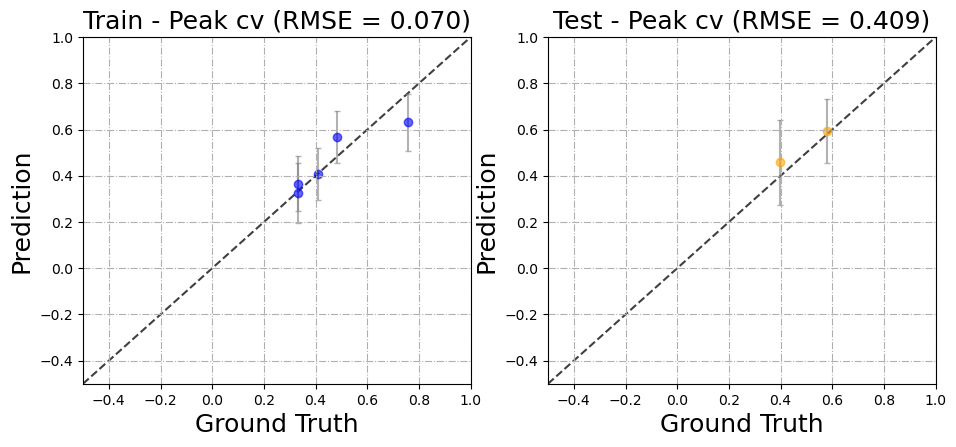

In [8]:
myplot([Train_y,Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-0.5,1])
#plt.savefig('result',dpi=1000)

In [9]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,6]/ss_y
m52 = GPy.kern.sde_Matern52(input_dim=5,ARD =True)
rbf =  GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
kernel = rbf
model = GPy.models.GPRegression(X_normalize,Y_normalize.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

Optimization restart 1/50, f = 1.0601584624599818
Optimization restart 2/50, f = 1.0601584991924184
Optimization restart 3/50, f = 1.0601584565983169
Optimization restart 4/50, f = 1.0601584558849972
Optimization restart 5/50, f = 1.0601584529235484
Optimization restart 6/50, f = 1.060158453814446
Optimization restart 7/50, f = 1.0601584805221118
Optimization restart 8/50, f = 1.0601584620932085
Optimization restart 9/50, f = 1.0601584549095335
Optimization restart 10/50, f = 1.0601584529328933
Optimization restart 11/50, f = 1.0601584534075208
Optimization restart 12/50, f = 1.0601584584870363
Optimization restart 13/50, f = 1.0601584568027596
Optimization restart 14/50, f = 1.0601584528148695
Optimization restart 15/50, f = 1.060158456645567
Optimization restart 16/50, f = 1.0601584585951525
Optimization restart 17/50, f = 1.060158457560247
Optimization restart 18/50, f = 1.0601584712803565
Optimization restart 19/50, f = 1.060158452245906
Optimization restart 20/50, f = 1.0601584632

 D:\Anaconda\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 D:\Anaconda\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:overflow encountered in multiply
 D:\Anaconda\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:overflow encountered in add
 D:\Anaconda\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 36/50, f = 1.0601584576847207
Optimization restart 37/50, f = 1.0601584551105487
Optimization restart 38/50, f = 1.0601584556557326
Optimization restart 39/50, f = 1.0601584613607207
Optimization restart 40/50, f = 1.0601584585983108
Optimization restart 41/50, f = 1.060158455793534
Optimization restart 42/50, f = 1.0601584575982077
Optimization restart 43/50, f = 1.0601584532126713
Optimization restart 44/50, f = 1.0601584633596897
Optimization restart 45/50, f = 1.892111375605439
Optimization restart 46/50, f = 1.0601584586915642
Optimization restart 47/50, f = 1.0601584541185023
Optimization restart 48/50, f = 1.0601584585697266
Optimization restart 49/50, f = 1.060158455964558
Optimization restart 50/50, f = 1.0601584653967118


 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


0.03426078674174727


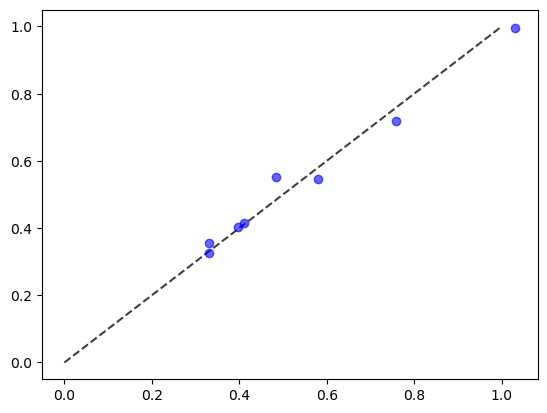

In [10]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([0,1],[0,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [11]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.021739130434782608, 1.0217391304347827)]

In [12]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 1

beta = [0.1,1,10]
recommend_point = []
num = 3
for i in range(num):

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = ss_y*model.predict(rp)[0] #均值
sigma = ss_y*model.predict(rp)[1] #方差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [ 0.98318072  0.43467212 -0.00366867 -0.01956027  0.18204272]
opt point :  (array([[ 1.00505051,  0.43467212, -0.00769231, -0.02      ,  0.18204272]]), array([[-0.1003245]]))
acq_max =  [[0.1003245]]
1000000
Init point :  [ 0.99638573  0.32772823 -0.0047998  -0.01077469  0.55683971]
opt point :  (array([[ 1.00505051,  0.32772823, -0.00769231, -0.02      ,  0.55683971]]), array([[-0.27819529]]))
acq_max =  [[0.27819529]]
1000000
Init point :  [ 0.011492    0.27275161  0.00157311 -0.01485542  0.89301078]
opt point :  (array([[-0.00505051,  0.27275161, -0.00769231, -0.02      ,  0.89301078]]), array([[-2.85024784]]))
acq_max =  [[2.85024784]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,50.0,230.0,500.0,50.0,6.0,-0.018154,0.010516
1,50.0,180.0,500.0,50.0,15.0,-0.018154,0.010516
2,0.5,150.0,500.0,50.0,23.0,0.044558,0.025197


In [13]:
final.to_excel('Intensity cv2_gp.xlsx')

In [21]:
rp

array([[0.        , 0.68421053, 0.        , 0.31111111, 1.        ],
       [1.        , 0.36842105, 0.        , 0.37777778, 1.        ],
       [1.        , 0.81578947, 0.        , 0.53333333, 1.        ]])

In [9]:
X_new

array([[ 1.00505051,  0.81757072, -0.00714286,  0.54268288,  1.01724138]])

In [13]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 10


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)



1000000


 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [0.46538428 0.14189202 0.20669397 0.79520894 0.14463125]
opt point :  (array([[0.46538428, 0.14189202, 0.20669397, 0.79520894, 0.14463125]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.40654548 0.65703494 0.76346659 0.34727138 0.48632265]
opt point :  (array([[0.40654548, 0.65703494, 0.76346659, 0.34727138, 0.48632265]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.12557292 0.40128067 0.79426988 0.73709175 0.88406021]
opt point :  (array([[0.12557292, 0.40128067, 0.79426988, 0.73709175, 0.88406021]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.37678209 0.36536233 0.96221431 0.80144208 0.06896802]
opt point :  (array([[0.37678209, 0.36536233, 0.96221431, 0.80144208, 0.06896802]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.23571933 0.96419597 0.47947772 0.2150342  0.19346971]
opt point :  (array([[0.23571933, 0.96419597, 0.47947772, 0.2150342 , 0.19346971]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.47399726 0.37574806 0.038228

In [14]:
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,23.5,71.0,1401.0,231.0,5.0,0.089949,0.018274
1,20.5,321.0,5301.0,101.0,15.0,0.095449,0.018264
2,6.5,201.0,5601.0,211.0,27.0,0.094399,0.018312
3,19.0,181.0,6701.0,231.0,3.0,0.094295,0.018200
4,12.0,471.0,3401.0,61.0,7.0,0.095618,0.018635
5,24.0,181.0,301.0,151.0,9.0,0.090790,0.018260
6,4.5,431.0,6801.0,171.0,4.0,0.097028,0.018564
7,26.5,451.0,5401.0,51.0,11.0,0.096664,0.018564
8,48.5,71.0,1101.0,71.0,2.0,0.089668,0.018312
9,18.5,241.0,3601.0,121.0,30.0,0.093762,0.018388
